In [1]:
using NPZ
using PyPlot
using SpecialFunctions

Unable to init server: Could not connect: Connection refused
Unable to init server: Could not connect: Connection refused

(.:14921): Gdk-CRITICAL **: 18:21:09.991: gdk_cursor_new_for_display: assertion 'GDK_IS_DISPLAY (display)' failed

(.:14921): Gdk-CRITICAL **: 18:21:10.006: gdk_cursor_new_for_display: assertion 'GDK_IS_DISPLAY (display)' failed


<a id='table_of_contents'></a>
# Table of Contents
1. [Loading crystal data](#loading_crystal_data)
2. [Sorting $i,j,k$](#sorting_ijk)
3. [Manybody potential at single $z$-slice](#manybody_potential_at_single_z-slice)
4. [3D manybody potential](#3d_manybody_potential)

<a id='loading_crystal_data'></a>
## Loading crystal data
[Table of Contents](#table_of_contents)

First, we load the data generated from [this notebook](effective_parameters_to_cylindrical_potential_MCM-41_PYTHON.ipynb).

In [2]:
#xyz atom positions withn the unit cell
mcm41_xyz_shifted = NPZ.npzread("data/mcm41_xyz_shifted_CVFF.npz");
mcm41_x = mcm41_xyz_shifted["x"];
mcm41_y = mcm41_xyz_shifted["y"];
mcm41_z = mcm41_xyz_shifted["z"];

#mixed sigma and epsilon parameters for the Lennard-Jones potential (helium and MCM-41 atoms)
sigma = mcm41_xyz_shifted["sigma"];
epsilon = mcm41_xyz_shifted["epsilon"];

In [3]:
#lattice vectors for MCM-41 unit cell
mcm41_lattice_vectors = NPZ.npzread("data/mcm41_lattice_vectors.npz");
A1 = mcm41_lattice_vectors["A1"];
A2 = mcm41_lattice_vectors["A2"];
A3 = mcm41_lattice_vectors["A3"];

Recall, we wish to generate the manybody potential within a single pore by summing a 12-6 Lennard-Jones potential over the atoms within a semi-infinite MCM-41 supercell
\begin{equation}
    U_\mathrm{MCM-41}^\mathrm{He}(\vec{r}) = \sum_{i,j,k = -\infty}^\infty \sum_\alpha^N 4\varepsilon_\alpha \biggl( \frac{\sigma_\alpha^{12}}{\lvert \vec{r} - \vec{r}_{ijk\alpha}\rvert^{12}} - \frac{\sigma_\alpha^6}{\lvert \vec{r} - \vec{r}_{ijk\alpha}\rvert^6} \biggr)
\end{equation}
where $\alpha$ indexes over each atom within the unit cell, $\varepsilon_\alpha$ and $\sigma_\alpha$ are the appropriately mixed Lennard-Jones parameters, and
\begin{equation}
\vec{r}_{ijk\alpha} = \vec{r}_\alpha + i\vec{A}_a + j\vec{A}_b + k\vec{A}_c
\end{equation}
is the position of each atom within the semi-infinite supercell with unit cell vectors $\vec{A}_{\{a,b,c\}}$.

The procedure will be to expand the unit cell in each unit cell direction and perform the summation until we reach the single precision floating point limit. Here we show a birds-eye view example of expanding once in each lattice vector direction.

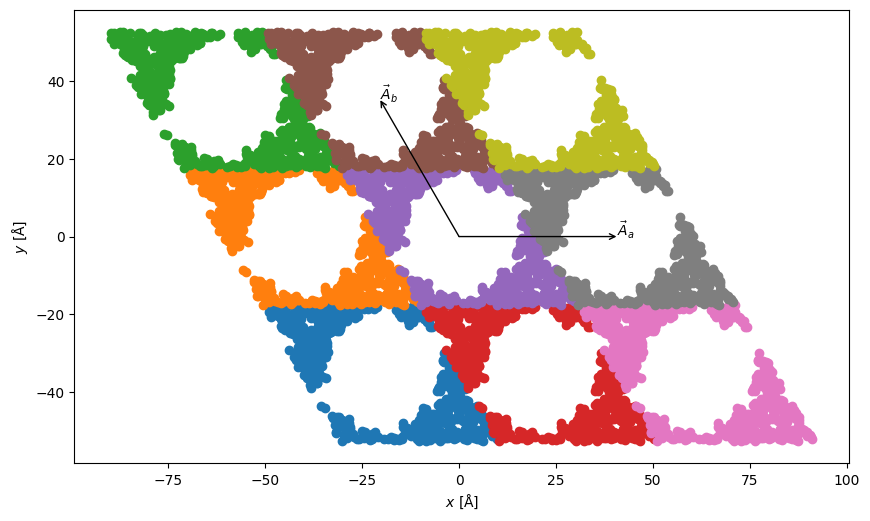

In [4]:
fig,ax = subplots(figsize=(10,10))
k = 0
for i in -1:1:1
    for j in -1:1:1
        _A = ((i .* A1) .+ (j .* A2) .+ (k .* A3))
        ax.scatter(mcm41_x .+ _A[1], mcm41_y .+ _A[2])
    end
end
ax.set_xlabel(L"$x\ \mathrm{[\AA]}$")
ax.set_ylabel(L"$y\ \mathrm{[\AA]}$")

arrowprops = PyPlot.PyDict()
arrowprops["arrowstyle"]="->"
arrowprops["shrinkA"]=0.0
arrowprops["shrinkB"]=0.0
ax.annotate("", xy=(A1[1], A1[2]), xytext=(0, 0), arrowprops=arrowprops)
ax.annotate(L"$\vec{A}_a$", xy=(A1[1], A1[2]))
ax.annotate("", xy=(A2[1], A2[2]), xytext=(0, 0), arrowprops=arrowprops)
ax.annotate(L"$\vec{A}_b$", xy=(A2[1], A2[2]))
ax.set_aspect("equal")

<a id='sorting_ijk'></a>
## Sorting $i,j,k$
[Table of Contents](#table_of_contents)

We created a sorted array over the summation integers $i,j,k$ since the atoms closest to the central pore will contribute the most the the manybody potential. The array is sorted by $\lvert\vec{r}_{ijk}\rvert=\lvert i\vec{A}_a + j\vec{A}_b + k\vec{A}_c \rvert$.

In [5]:
# we create a large collection of ijk indices
i_arr = collect(-200:1:200);
j_arr = collect(-200:1:200);
k_arr = collect(-200:1:200);
r_arr  = Array{Float64,3}(undef,size(i_arr,1),size(j_arr,1),size(k_arr,1));

In [6]:
# Here we find the magnitude to center of each replicated unit cell within the very large supercell
for i in i_arr
    for j in j_arr
        for k in k_arr
            _A = ((i .* A1) .+ (j .* A2) .+ (k .* A3));
            _r = sqrt(sum(_A.^2))
            r_arr[i+201,j+201,k+201] = _r
        end
    end
end

In [8]:
#initialize and fill the arrays to hold the combinations of ijk
_i_arr = Array{Int64,3}(undef,size(i_arr,1),size(j_arr,1),size(k_arr,1));
_j_arr = Array{Int64,3}(undef,size(i_arr,1),size(j_arr,1),size(k_arr,1));
_k_arr = Array{Int64,3}(undef,size(i_arr,1),size(j_arr,1),size(k_arr,1));

for i in i_arr
    for j in j_arr
        for k in k_arr
            _i_arr[i+201,j+201,k+201] = i
            _j_arr[i+201,j+201,k+201] = j
            _k_arr[i+201,j+201,k+201] = k
        end
    end
end

In [9]:
#flatten each ijk array and sort by the distance to each unit cell within the supercell
r_arr_flat = vec(r_arr);
_i_arr_flat = vec(_i_arr);
_j_arr_flat = vec(_j_arr);
_k_arr_flat = vec(_k_arr);

p = sortperm(r_arr_flat); #get the index for sorting by distance

r_arr_flat = r_arr_flat[p];
_i_arr_flat = _i_arr_flat[p];
_j_arr_flat = _j_arr_flat[p];
_k_arr_flat = _k_arr_flat[p];

<a id='manybody_potential_at_single_z-slice'></a>
## Manybody potential at single $z$-slice
[Table of Contents](#table_of_contents)

Now that we have sorted the summation indeces for a suitably large supercell, we can calculate the manybody potential at a single $z$-slice within a nanopore in the MCM-41. First we define the Lennard-Jones potential functions.

In [10]:
function U(r::Float64,sigma::Float64,epsilon::Float64)
    pf = 4 * epsilon;
    t12 = (sigma/r)^12;
    t6 = (sigma/r)^6;
    return pf * (t12 - t6)
end

function U(r::Float32,sigma::Float32,epsilon::Float32)
    pf = 4 * epsilon;
    t12 = (sigma/r)^12;
    t6 = (sigma/r)^6;
    return pf * (t12 - t6)
end

function U(r::Float64,sigma::Float64,epsilon::Float64)
    pf = 4 * epsilon;
    t12 = (sigma/r)^12;
    t6 = (sigma/r)^6;
    return pf * (t12 - t6)
end

function U_mb(r::Array{Float64,1},sigma::Array{Float64,1},epsilon::Array{Float64,1})
    V = 0.0;
    @inbounds for i in 1:size(r)
        V += U(r[i],sigma[i],epsilon[i]);
    end
    return V
end

U_mb (generic function with 1 method)

Next, we generate a mesh of points in the xy-plane ecompassing the pore.

In [12]:
x_min = -20.0;
x_max = 20.0;
y_min = -20.0;
y_max = 20.0;
res = 101;
x = zeros(res,res);
y = zeros(res,res);
x_range = collect(range(x_min,x_max,length=res));
y_range = collect(range(y_min,y_max,length=res));
for i in 1:res
    _x = x_range[i];
    for j in 1:res
        _y = y_range[j];
        x[i,j] = _x;
        y[i,j] = _y;
    end
end

Now we convert some the variables to Julia Float32 types since we are calculating the manybody potential to within the single precision floating point limit.

In [17]:
r_tmp = zeros(Float32,size(x));

x32 = convert.(Float32,x);
y32 = convert.(Float32,y);

A1_32 = convert.(Float32,A1);
A2_32 = convert.(Float32,A2);
A3_32 = convert.(Float32,A3);

# We will look at the z-slice for z=0.0 Angstroms
Z_VALUE = 0.0;
Z_VALUE32 = convert(Float32,Z_VALUE);

V = zeros(Float32,size(x32));
V_old = zeros(Float32,size(x32));

Finally, everything is set up to generate the manybody potential at a single $z$-slice.

In [18]:
ii_max = 10000 #Set some maximum just in case
for ii = 1:ii_max
    i = _i_arr_flat[ii];
    j = _j_arr_flat[ii];
    k = _k_arr_flat[ii];
    for atom in 1:size(mcm41_x,1)
        # get distance to single atom within supercell
        r_tmp .= sqrt.(((mcm41_x[atom] + (A1_32[1]*i) + (A2_32[1]*j)) .- x32).^2 .+ ((mcm41_y[atom] + (A2_32[2]*j)) .- y32).^2 .+ ((mcm41_z[atom] + (A3_32[3]*k)) - Z_VALUE32)^2);
        
        #Calculate the Lennard-Jones potential at the separation for helium and MCM-41 atom and increment the total potential
        V .+= U.(r_tmp,sigma[atom],epsilon[atom])
    end
    if all(V .== V_old)
        # if the old potential is the same as the new potential for
        # every point within the xy-mesh, then we have reached the
        # single precision floating point limit
        println(ii) # Show progress for each slice iteration
        break
    elseif (ii == ii_max)
        println("WARNING: ii_max reached")
        break
    else
        # if we haven't reached the stopping critereon, copy current potential
        copy!(V_old,V);
    end
end


574


We have calculated the manybody potential for a single $z$-slice. Here is a view of the potential.

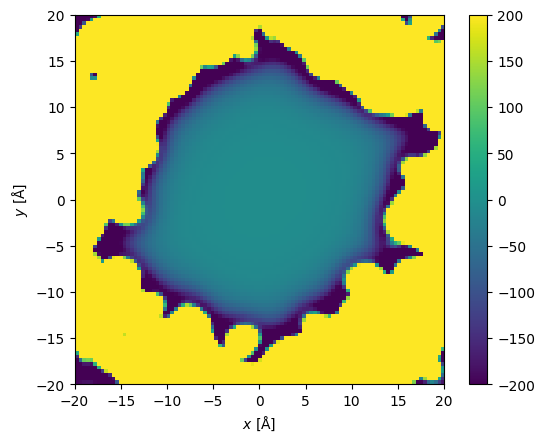

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd871545e10>

In [20]:
extent = (-20.0,20.0,-20.0,20.0)
fig,ax = plt.subplots()
im = ax.imshow(transpose(V),origin="lower",vmax=200,vmin=-200,extent=extent)
ax.set_xlabel(L"$x\ \mathrm{[\AA]}$")
ax.set_ylabel(L"$y\ \mathrm{[\AA]}$")
fig.colorbar(im)

<a id='3d_manybody_potential'></a>
## 3D manybody potential
[Table of Contents](#table_of_contents)

Now that we have seen how to calculate the manybody potential for a single slice, we are ready to caculate the full 3D manybody potential. Here, we will calculate from the bottom of the single unitcell to the top.

In [22]:
z_min = -A3[3]/2; # bottom of unit cell
z_max = A3[3]/2; # top of unit cell
z_range = collect(range(z_min,z_max,length=res));

V_3D = zeros(Float32,size(x32,1),size(x32,2),res); # initialize 3D potential

In [35]:
for jj in 1:res
    print("jj = $jj: ") # A more descriptive output for each slice
    Z_VALUE = z_range[jj];
    Z_VALUE32 = convert(Float32,Z_VALUE);
    V = zeros(Float32,size(x32));
    V_old = zeros(Float32,size(x32));
    ii_max = 10000
    for ii = 1:ii_max
        i = _i_arr_flat[ii];
        j = _j_arr_flat[ii];
        k = _k_arr_flat[ii];
        for atom in 1:size(mcm41_x,1)
            r_tmp .= sqrt.(((mcm41_x[atom] + (A1_32[1]*i) + (A2_32[1]*j)) .- x32).^2 .+ ((mcm41_y[atom] + (A2_32[2]*j)) .- y32).^2 .+ ((mcm41_z[atom] + (A3_32[3]*k)) - Z_VALUE32)^2);
            V .+= U.(r_tmp,sigma[atom],epsilon[atom])
        end
        if all(V .== V_old)
            println(ii)
            break
        elseif (ii == ii_max)
            break
        else
            copy!(V_old,V);
        end
    end
    V_3D[:,:,jj] .= V;
end

jj = 1: 1009
jj = 2: 383
jj = 3: 1402
jj = 4: 575
jj = 5: 1010
jj = 6: 383
jj = 7: 557
jj = 8: 575
jj = 9: 1471
jj = 10: 2078
jj = 11: 385
jj = 12: 587
jj = 13: 313
jj = 14: 1083
jj = 15: 383
jj = 16: 313
jj = 17: 575
jj = 18: 704
jj = 19: 575
jj = 20: 1404
jj = 21: 575
jj = 22: 441
jj = 23: 739
jj = 24: 385
jj = 25: 575
jj = 26: 1180
jj = 27: 2117
jj = 28: 739
jj = 29: 1143
jj = 30: 312
jj = 31: 431
jj = 32: 440
jj = 33: 1143
jj = 34: 1180
jj = 35: 312
jj = 36: 2877
jj = 37: 1143
jj = 38: 575
jj = 39: 794
jj = 40: 849
jj = 41: 709
jj = 42: 312
jj = 43: 848
jj = 44: 3022
jj = 45: 689
jj = 46: 501
jj = 47: 440
jj = 48: 849
jj = 49: 836
jj = 50: 440
jj = 51: 574
jj = 52: 440
jj = 53: 849
jj = 54: 1530
jj = 55: 574
jj = 56: 789
jj = 57: 440
jj = 58: 440
jj = 59: 1394
jj = 60: 574
jj = 61: 1595
jj = 62: 1180
jj = 63: 312
jj = 64: 551
jj = 65: 2103
jj = 66: 1494
jj = 67: 574
jj = 68: 574
jj = 69: 428
jj = 70: 312
jj = 71: 312
jj = 72: 2116
jj = 73: 574
jj = 74: 1136
jj = 75: 574
jj = 76: 55

Now that we have the 3D manybody potential, we can save it and continue our analysis in the [effective parameters to cylindrical potential notebook](effective_parameters_to_cylindrical_potential_MCM-41_PYTHON.ipynb#determining_the_effective_parameters_to_cylindrical_potential).

In [41]:
NPZ.npzwrite("data/V_3D_-20.0_20.0_-20.0_20.0_-6.10_6.10_101_CVFF.npz",
    Dict("x_range"  => convert.(Float32,x_range),
         "y_range"  => convert.(Float32,y_range),
         "z_range"  => convert.(Float32,z_range),
         "V" => V_3D,
         "x_grid" => x32,
         "y_grid" => y32,
         "extent" => convert.(Float32,[x_min,x_max,y_min,y_max])
        ))